## 1. Import Libraries

In [1]:
import os
import sys
import torch
import zipfile
import numpy as np # number python
from torch import nn # neural network (Conv2D - 2D Convolution Layer, Linear, Logistic)
from torch.nn import functional as F # activation function (ReLU, Sigmoid, SoftMax)
import torch.utils.data as td # tools to create & load dataset
import torchvision as tv # torchvision library for computer vision tasks
import pandas as pd # library for data analysis, manipulation -> data augmentation
from PIL import Image # library used for image handling
from matplotlib import pyplot as plt # plotting library to plot & visualize results
from sklearn.model_selection import train_test_split # function used to split training set

In [2]:
print(f'PyTorch Version: {torch.__version__}')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)
print(torch.cuda.get_device_name())

try: 
    print(f'CUDA Version: {torch.version.cuda}')
except:
    pass

PyTorch Version: 2.5.1+cu121
cuda
NVIDIA GeForce RTX 4070 Laptop GPU
CUDA Version: 12.1


## 2. Loading & Processing Dataset

### Dataset Location

In [3]:
dataset_root_dir = 'E:/Year 3 Sem 1/COS30082 Applied Machine Learning/Assignment_1/Dataset/'

### Data Processing 

#### Data Augmentation

In [4]:
class BirdDataset(td.Dataset): 
    def __init__(self, root_dir, mode="train", image_size=(224,224), transform=None):
        super().__init__()
        self.image_size = image_size
        self.mode = mode
        self.custom_transform = transform  # Rename to avoid confusion
        
        # Determine which txt file to use based on mode
        if mode == "train":
            txt_path = os.path.join(root_dir, 'train_split.txt')
        elif mode == "val":
            txt_path = os.path.join(root_dir, 'val_split.txt')
        else:  # mode == "test"
            txt_path = os.path.join(root_dir, 'test.txt')
        
        # Set images directory - train and val both use Train folder
        if mode in ["train", "val"]:
            self.images_dir = os.path.join(root_dir, 'Train')
        else:  # mode == "test"
            self.images_dir = os.path.join(root_dir, 'Test')
        
        # Loading .txt file
        print(f"Text File: {txt_path}")
        print(f"Images Directory: {self.images_dir}")
        self.data = pd.read_csv(txt_path, sep=" ", header=None, names=["file_path", "class"])
        print(f"Loaded {len(self.data)} samples for {mode} mode")
        
        # Define training transform (with augmentation)
        self.train_transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            tv.transforms.RandomHorizontalFlip(),
            tv.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
        ])
        
        # Define validation/test transform (no augmentation)
        self.val_transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            tv.transforms.CenterCrop(self.image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.data)
    
    def __repr__(self):
        return f"BirdDataset(mode='{self.mode}', size={len(self)}, image_size={self.image_size})"
    
    def __getitem__(self, idx):
        # Get image path and label
        img_path = os.path.join(self.images_dir, self.data.iloc[idx]['file_path'])
        
        # Try to load image with error handling
        try:
            img = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"Warning: Image not found: {img_path}")
            # Create a black placeholder image
            img = Image.new('RGB', self.image_size, color='black')
        
        label = self.data.iloc[idx]['class']
        
        # Choose which transform to apply
        if self.custom_transform is not None:
            # Use custom transform if provided
            img = self.custom_transform(img)
        elif self.mode == "train":
            # Use training transform (with augmentation)
            img = self.train_transform(img)
        else:  # mode == "val" or "test"
            # Use validation transform (no augmentation)
            img = self.val_transform(img)
        
        return img, label
    
    def number_of_classes(self):
        return self.data['class'].max() + 1

### View Modified Dataset

In [5]:
def show_img(image, ax=plt):
    # ax = axies object, plot area. ax=plt means default value for ax parameter

    image = image.to('cpu').numpy()
    # moves the tensor to the CPU because Matplotlib can only work with NumPy arrays that are on the CPU, not PyTorch tensors on the GPU.
    
    image = np.moveaxis(image, [0,1,2], [2,0,1])
    # Matplotlib expects different axes (H,W,C) compared to PyTorch (C,W,H)

    image = (image + 1) / 2
    # Unnormalize image

    image[image < 0] = 0
    image[image > 1] = 1

    i = ax.imshow(image)
    # matplotlib function that displays image

    ax.axis("off")

    return i

In [6]:
# Get sample from Training Set

# Create instance of dataset class (BirdDataset)
train_set = BirdDataset(dataset_root_dir)
x = train_set[10]

Text File: E:/Year 3 Sem 1/COS30082 Applied Machine Learning/Assignment_1/Dataset/train_split.txt
Images Directory: E:/Year 3 Sem 1/COS30082 Applied Machine Learning/Assignment_1/Dataset/Train
Loaded 3863 samples for train mode


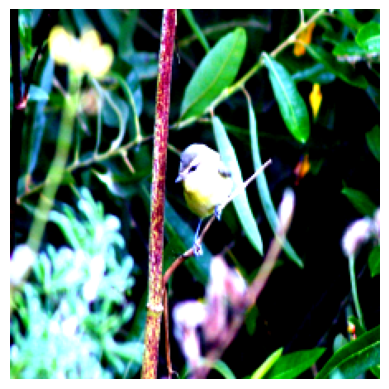

In [7]:
# Create Figure
plt.figure()
show_img(x[0])
# x is from the sample, and 0 is the index for image array x

### Loading Data

In [8]:
# Load Data thoruhg mini-batch size
train_loader = td.DataLoader(train_set, batch_size=32, shuffle = True, pin_memory = True)
# Use mini-batch size 16
# Shufffle so that the model does not predict based off data order
# pin_memory = True -> Speeds up transfer to the GPU

In [9]:
# How many mini-batches there are.
len(train_loader)

121

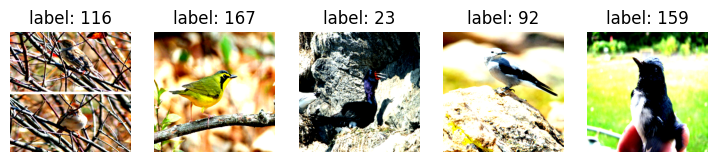

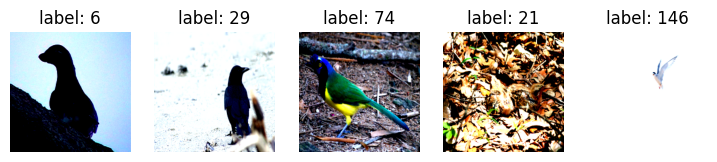

In [10]:
for _ in range(2):
   # _ is a throwaway variable
    fig, axes = plt.subplots(ncols=5, figsize=(9, 3))
    # Create Matplotlib figure with 5 subplots 
    for batch_idx, batch in enumerate(train_loader):
        if batch_idx == 5: 
            break
        show_img(batch[0][0], ax=axes[batch_idx])
        # batch[0] -> images tensor of the batch, batch[0][0] -> images tensor index (0 being the first index)
        # ax tells the image to plot on their respective subplot
        axes[batch_idx].set_title(f'label: {batch[1][0]}')
        # batch[1] -> represents the class label no.
        

Batch is a tuple(images, labels). Batch[0] represents Image Tensor and Batch[1] represents Labels Tensor

# 3. Splitting Validation Dataset

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
txt_path = os.path.join(dataset_root_dir, "train.txt")
full_data = pd.read_csv(txt_path, sep=" ", header=None, names=["file_path", "class"])

In [13]:
train_df, val_df = train_test_split(
    full_data,
    test_size=0.2,          # 20% for validation
    random_state=42,        # for reproducibility
    stratify=full_data['class']  # preserve class distribution
)

In [14]:
train_split_path = os.path.join(dataset_root_dir, "train_split.txt")
val_split_path = os.path.join(dataset_root_dir, "val_split.txt")

train_df.to_csv(train_split_path, sep=" ", header=False, index=False)
val_df.to_csv(val_split_path, sep=" ", header=False, index=False)

In [15]:
train_set = BirdDataset(dataset_root_dir, mode="train")
val_set = BirdDataset(dataset_root_dir, mode="val")

Text File: E:/Year 3 Sem 1/COS30082 Applied Machine Learning/Assignment_1/Dataset/train_split.txt
Images Directory: E:/Year 3 Sem 1/COS30082 Applied Machine Learning/Assignment_1/Dataset/Train
Loaded 3863 samples for train mode
Text File: E:/Year 3 Sem 1/COS30082 Applied Machine Learning/Assignment_1/Dataset/val_split.txt
Images Directory: E:/Year 3 Sem 1/COS30082 Applied Machine Learning/Assignment_1/Dataset/Train
Loaded 966 samples for val mode


In [16]:
test_set = BirdDataset(dataset_root_dir, mode="test")

Text File: E:/Year 3 Sem 1/COS30082 Applied Machine Learning/Assignment_1/Dataset/test.txt
Images Directory: E:/Year 3 Sem 1/COS30082 Applied Machine Learning/Assignment_1/Dataset/Test
Loaded 1204 samples for test mode


### Classifier Class

In [17]:
import torch.nn as nn

In [18]:
class Classifier(nn.Module):

    def __init__(self):
        super(Classifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def criterion(self, y, d):
        return self.cross_entropy(y, d)

## 4. Transfer Learning - Convolutional Neural Network

### Load Pre-trained VGG Model

In [19]:
from torchvision.models import VGG16_BN_Weights, vgg16_bn

In [20]:
vgg = tv.models.vgg16_bn(pretrained = True)
# // vgg = vgg16_bn(weights=VGG16_BN_Weights.IMAGENET1K_V)

C:\Users\benji\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\benji\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [22]:
# List all the parameters in the transferred model
for name, param in vgg.named_parameters():
    print(name, param.size(), param.requires_grad)

# features.0.weight torch.Size([64, 3, 3, 3]) True
# Outputs: 64 Filters, 3 input channels, 3 x 3 kernel size 

features.0.weight torch.Size([64, 3, 3, 3]) True
features.0.bias torch.Size([64]) True
features.1.weight torch.Size([64]) True
features.1.bias torch.Size([64]) True
features.3.weight torch.Size([64, 64, 3, 3]) True
features.3.bias torch.Size([64]) True
features.4.weight torch.Size([64]) True
features.4.bias torch.Size([64]) True
features.7.weight torch.Size([128, 64, 3, 3]) True
features.7.bias torch.Size([128]) True
features.8.weight torch.Size([128]) True
features.8.bias torch.Size([128]) True
features.10.weight torch.Size([128, 128, 3, 3]) True
features.10.bias torch.Size([128]) True
features.11.weight torch.Size([128]) True
features.11.bias torch.Size([128]) True
features.14.weight torch.Size([256, 128, 3, 3]) True
features.14.bias torch.Size([256]) True
features.15.weight torch.Size([256]) True
features.15.bias torch.Size([256]) True
features.17.weight torch.Size([256, 256, 3, 3]) True
features.17.bias torch.Size([256]) True
features.18.weight torch.Size([256]) True
features.18.bi

### Fine-Tuning & Freezing

In [23]:
import nntools as nt

In [24]:
class VGG16(Classifier):
    def __init__(self, num_classes, fine_tuning=False, dropout_p=0.5):
        super().__init__()
        # Load pretrained VGG16 with batchnorm
        vgg = tv.models.vgg16_bn(pretrained=True)
        
        # Freeze parameters if not fine-tuning
        # for param in vgg.parameters():
           # param.requires_grad = fine_tuning


        for name, param in vgg.features.named_parameters():
            layer_idx = int(name.split('.')[0])  # extract the index before the dot
            if layer_idx in [0, 3, 7]:          # only freeze these specific layers
                param.requires_grad = False


        
        self.features = vgg.features

        # Droupout Value
        dropout_p = 0.5
        
        # Customize classifier
        num_ftrs = vgg.classifier[0].in_features if hasattr(vgg.classifier[0], 'in_features') else 25088
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 1024),
            nn.ReLU(True),
            nn.Dropout(dropout_p),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Dropout(dropout_p),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        f = self.features(x).view(x.shape[0], -1)
        y = self.classifier(f)
        return y


In [25]:
num_classes = train_set.number_of_classes()

In [26]:
vgg16transfer = VGG16(num_classes)

In [27]:
vgg16transfer

VGG16(
  (cross_entropy): CrossEntropyLoss()
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

In [28]:
for name, param in vgg16transfer.named_parameters():
    print(name, param.size(), param.requires_grad)

features.0.weight torch.Size([64, 3, 3, 3]) False
features.0.bias torch.Size([64]) False
features.1.weight torch.Size([64]) True
features.1.bias torch.Size([64]) True
features.3.weight torch.Size([64, 64, 3, 3]) False
features.3.bias torch.Size([64]) False
features.4.weight torch.Size([64]) True
features.4.bias torch.Size([64]) True
features.7.weight torch.Size([128, 64, 3, 3]) False
features.7.bias torch.Size([128]) False
features.8.weight torch.Size([128]) True
features.8.bias torch.Size([128]) True
features.10.weight torch.Size([128, 128, 3, 3]) True
features.10.bias torch.Size([128]) True
features.11.weight torch.Size([128]) True
features.11.bias torch.Size([128]) True
features.14.weight torch.Size([256, 128, 3, 3]) True
features.14.bias torch.Size([256]) True
features.15.weight torch.Size([256]) True
features.15.bias torch.Size([256]) True
features.17.weight torch.Size([256, 256, 3, 3]) True
features.17.bias torch.Size([256]) True
features.18.weight torch.Size([256]) True
features

In [29]:
class ClassificationStatsManager(nt.StatsManager):

    def __init__(self):
        super(ClassificationStatsManager, self).__init__()

    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0

    def accumulate(self, loss, x, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d)
        _, l = torch.max(y, 1)
        self.running_accuracy += torch.mean((l == d).float())

    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize()
        accuracy = 100 * self.running_accuracy / self.number_update
        return {'loss': loss, 'accuracy': accuracy}


#### Learning Rate 1

In [36]:
lr = 5e-5
net = VGG16(num_classes = num_classes, fine_tuning=True).to(device)
net = net.to(device)
net.device = device

adam = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr, weight_decay = 1e-4)

stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
               output_dir="birdclass1", perform_validation_during_training=True)

E:\Year 3 Sem 1\COS30082 Applied Machine Learning\Assignment_1\nntools.py:231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.checkpoint_path,


In [37]:
with open("birdclass1/config.txt", "r") as f:
    print(f.read())

Net(VGG16(
  (cross_entropy): CrossEntropyLoss()
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [38]:
#lr = 1e-4
#net = VGG16(num_classes)
#net = net.to(device)
adam = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr, weight_decay = 1e-4)
#stats_manager = ClassificationStatsManager()
try:
    #exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
    #          output_dir="birdclass1", perform_validation_during_training=True)

    exp1 = nt.Experiment(
        net, train_set, val_set, adam, stats_manager,
        output_dir="birdclass1",
        perform_validation_during_training=True
    )
except ValueError:
    print("ValueError: Cannot create this experiment: I found a checkpoint conflicting with the current setting.")

#### Training Snippet

##### Early Stopping

In [39]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        """
        Args:
            patience: number of epochs to wait after last improvement
            min_delta: minimum change to consider as improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.should_stop = False

    def step(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # reset counter if improvement
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True

In [40]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()
    
    def to_float(x):
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().item()
        return x

    # Training and Validation loss
    axes[0].plot([to_float(exp.history[k][0]['loss']) for k in range(exp.epoch)],
                 label="training loss")
    axes[0].plot([to_float(exp.history[k][1]['loss']) for k in range(exp.epoch)],
                 label="Validation loss")
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    # Training and Validation accuracy
    axes[1].plot([to_float(exp.history[k][0]['accuracy']) for k in range(exp.epoch)],
                 label="training accuracy")
    axes[1].plot([to_float(exp.history[k][1]['accuracy']) for k in range(exp.epoch)],
                 label="Validation accuracy")
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend(loc='lower right')

    # Add text for current epoch
    axes[0].text(0.95, 0.95, f"Epoch {exp.epoch}", 
                 transform=axes[0].transAxes, ha='right', va='top',
                 fontsize=12, bbox=dict(facecolor='white', alpha=0.6))
    
    plt.tight_layout()
    fig.canvas.draw()

In [41]:
# fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
# exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

### Resume Training Experiment

Start/Continue training from epoch 40
Finish training for 40 epochs


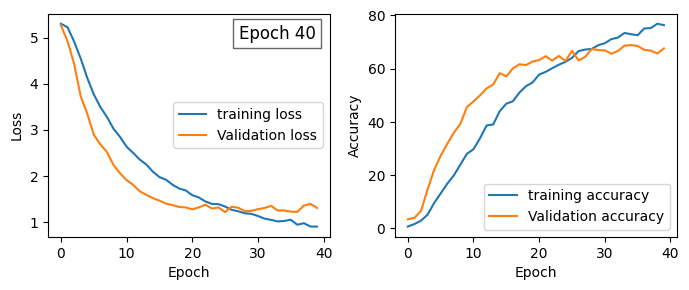

In [42]:
# Continue training from the current epoch
start_epoch = exp1.epoch  
max_epochs = 40

fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
early_stopping = EarlyStopping(patience=5, min_delta=0.01)

exp1.run(num_epochs=max_epochs, plot=lambda exp: plot(exp, fig=fig, axes=axes))


### Starting Training

Start/Continue training from epoch 40
Finish training for 1 epochs
Start/Continue training from epoch 40
Finish training for 2 epochs
Start/Continue training from epoch 40
Finish training for 3 epochs
Start/Continue training from epoch 40
Finish training for 4 epochs
Start/Continue training from epoch 40
Finish training for 5 epochs
Start/Continue training from epoch 40
Finish training for 6 epochs
Stopping early at epoch 40


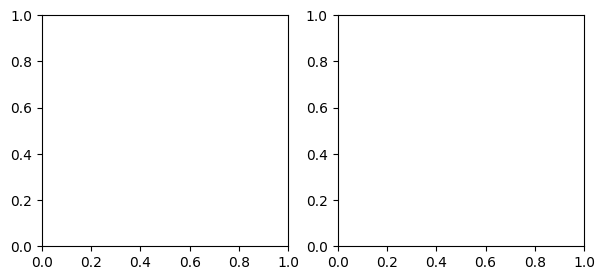

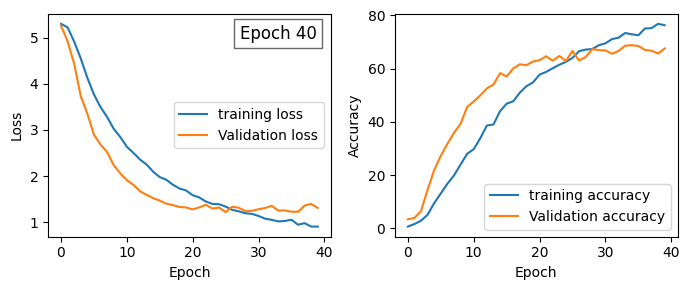

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3)) 

early_stopping = EarlyStopping(patience=10, min_delta=0.01)
max_epochs = 40
early_stopping = EarlyStopping(patience=5)

fig, axes = plt.subplots(ncols=2, figsize=(7, 3))

for epoch in range(max_epochs):
    exp1.run(num_epochs=epoch + 1, plot=lambda exp: plot(exp, fig=fig, axes=axes))
    
    # Get latest validation loss
    val_loss = exp1.history[-1][1]['loss']  # -1 = last epoch
    
    early_stopping.step(val_loss)
    
    if early_stopping.should_stop:
        print(f"Stopping early at epoch {exp1.epoch}")
        break

#### Top-1 Accuracy

In [44]:
import torch
from sklearn.metrics import accuracy_score

def compute_top1_accuracy(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    top1_acc = accuracy_score(all_labels, all_preds)
    print(f"Top-1 Accuracy: {top1_acc * 100:.2f}%")
    return all_labels, all_preds

In [45]:
from torch.utils.data import DataLoader

# Create loaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=False)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# Compute accuracies
print("🔹 Training Set:")
y_true_train, y_pred_train = compute_top1_accuracy(net, train_loader, device)

print("🔹 Validation Set:")
y_true_val, y_pred_val = compute_top1_accuracy(net, val_loader, device)

print("🔹 Test Set:")
y_true_test, y_pred_test = compute_top1_accuracy(net, test_loader, device)


🔹 Training Set:
Top-1 Accuracy: 96.22%
🔹 Validation Set:
Top-1 Accuracy: 67.49%
🔹 Test Set:
Top-1 Accuracy: 66.45%


#### Average Accuracy Per Class

In [47]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from data_utils import extract_class_names_from_dataset 

class_names = extract_class_names_from_dataset(test_set)

cm = confusion_matrix(y_true_test, y_pred_test)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
avg_class_acc = np.mean(per_class_acc)

print(f"Average Accuracy per Class: {avg_class_acc * 100:.2f}%")

print(classification_report(y_true_test, y_pred_test, target_names=class_names))

Average Accuracy per Class: 65.76%
              precision    recall  f1-score   support

                   0.57      0.57      0.57         7
                   0.56      1.00      0.71         5
                   0.43      0.60      0.50         5
                   0.75      0.86      0.80         7
                   0.33      0.20      0.25         5
                   0.67      0.33      0.44         6
                   0.46      0.86      0.60         7
                   0.83      0.83      0.83         6
                   0.75      0.60      0.67         5
                   1.00      0.80      0.89         5
                   0.50      0.40      0.44         5
                   0.75      1.00      0.86         6
                   0.80      0.80      0.80         5
                   0.83      0.71      0.77         7
                   0.50      0.33      0.40         6
                   1.00      0.50      0.67         6
                   0.33      0.40      0.36   

In [ ]:
#plt.figure(figsize=(12, 10))
#sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
#            xticklabels=class_names, yticklabels=class_names)
#plt.title("Confusion Matrix")
#plt.xlabel("Predicted")
#plt.ylabel("True")
#plt.show()

In [ ]:
#plt.figure(figsize=(12, 5))
#plt.bar(range(len(class_names)), per_class_acc * 100)
#plt.xticks(range(len(class_names)), class_names, rotation=90)
#plt.ylabel("Accuracy (%)")
#plt.title("Per-Class Accuracy")
#plt.tight_layout()
#plt.show()

In [48]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from data_utils import extract_class_names_from_dataset  # ✅ correct import

# Assuming y_true and y_pred are already defined
class_names = extract_class_names_from_dataset(test_set)

# Confusion Matrix
cm = confusion_matrix(y_true_test, y_pred_test)

# 🔹 Compute macro mean (macro-average recall)
macro_mean_acc = recall_score(y_true_test, y_pred_test, average='macro')

print(f"Macro Mean Accuracy (per class average): {macro_mean_acc * 100:.2f}%")

# Optional: manual version (sanity check)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
manual_macro_mean = np.mean(per_class_acc)
print(f"Manual Macro Mean Accuracy: {manual_macro_mean * 100:.2f}%")

# Classification Report
print(classification_report(y_true_test, y_pred_test, target_names=class_names))

Macro Mean Accuracy (per class average): 65.76%
Manual Macro Mean Accuracy: 65.76%
              precision    recall  f1-score   support

                   0.57      0.57      0.57         7
                   0.56      1.00      0.71         5
                   0.43      0.60      0.50         5
                   0.75      0.86      0.80         7
                   0.33      0.20      0.25         5
                   0.67      0.33      0.44         6
                   0.46      0.86      0.60         7
                   0.83      0.83      0.83         6
                   0.75      0.60      0.67         5
                   1.00      0.80      0.89         5
                   0.50      0.40      0.44         5
                   0.75      1.00      0.86         6
                   0.80      0.80      0.80         5
                   0.83      0.71      0.77         7
                   0.50      0.33      0.40         6
                   1.00      0.50      0.67         

#### Validation Accuracy

In [ ]:
# evaluation of vgg
exp1.evaluate()

## 5. Transfer Learning 2 - ResNet18

In [49]:
resnet = tv.models.resnet18(pretrained=True)

C:\Users\benji\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\benji\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [50]:
# network structure
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [51]:
class Resnet18Transfer(Classifier):
    def __init__(self, num_classes, fine_tuning=False, dropout_p=0.5): # Add dropout probability as an argument
        super(Resnet18Transfer, self).__init__()
        resnet = tv.models.resnet18(pretrained=True)
        
        for param in resnet.parameters():
            param.requires_grad = fine_tuning
            
        self.classifier = resnet
        num_ftrs = resnet.fc.in_features
        
        self.classifier.fc = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):     
        y = self.classifier(x)
        return y

In [52]:
resnet18transfer = Resnet18Transfer(num_classes)

In [53]:
# network structure
resnet18transfer

Resnet18Transfer(
  (cross_entropy): CrossEntropyLoss()
  (classifier): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(6

In [54]:
# learnable parameters of network
for name, param in resnet18transfer.named_parameters():
    print(name, param.size(), param.requires_grad)

classifier.conv1.weight torch.Size([64, 3, 7, 7]) False
classifier.bn1.weight torch.Size([64]) False
classifier.bn1.bias torch.Size([64]) False
classifier.layer1.0.conv1.weight torch.Size([64, 64, 3, 3]) False
classifier.layer1.0.bn1.weight torch.Size([64]) False
classifier.layer1.0.bn1.bias torch.Size([64]) False
classifier.layer1.0.conv2.weight torch.Size([64, 64, 3, 3]) False
classifier.layer1.0.bn2.weight torch.Size([64]) False
classifier.layer1.0.bn2.bias torch.Size([64]) False
classifier.layer1.1.conv1.weight torch.Size([64, 64, 3, 3]) False
classifier.layer1.1.bn1.weight torch.Size([64]) False
classifier.layer1.1.bn1.bias torch.Size([64]) False
classifier.layer1.1.conv2.weight torch.Size([64, 64, 3, 3]) False
classifier.layer1.1.bn2.weight torch.Size([64]) False
classifier.layer1.1.bn2.bias torch.Size([64]) False
classifier.layer2.0.conv1.weight torch.Size([128, 64, 3, 3]) False
classifier.layer2.0.bn1.weight torch.Size([128]) False
classifier.layer2.0.bn1.bias torch.Size([128])

In [ ]:
lr2 = 1e-4
net2 = Resnet18Transfer(num_classes, dropout_p=0.5)
net2 = Resnet18Transfer(num_classes)
net2 = net2.to(device)
net2.device = device

adam2 = torch.optim.Adam(net2.parameters(), lr=lr2, weight_decay=1e-4)
stats_manager2 = ClassificationStatsManager()
exp2 = nt.Experiment(net2, train_set, val_set, adam2, stats_manager2,
               output_dir="birdclass2", perform_validation_during_training=True)

In [ ]:
import numpy as np
import torch

class EarlyStopper2:
    """Stops training when validation loss doesn't improve for a given number of epochs."""
    def __init__(self, patience=5, verbose=False, delta=0, path='best_model.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
patience = 5
early_stopper = EarlyStopper2(patience=patience, verbose=True, path='birdclass_best_model.pt')

def plot_and_early_stop_callback(exp):
    plot(exp, fig=fig, axes=axes)

    if len(exp.history) > 0:
        latest_entry = exp.history[-1]

        # New: extract train/val losses safely from the dicts
        train_stats, val_stats = latest_entry

        latest_train_loss = train_stats.get('loss', None)
        latest_val_loss = val_stats.get('loss', None)

        if latest_val_loss is None:
            print("⚠️ Validation loss missing — using training loss for early stopping instead.")
            latest_val_loss = latest_train_loss
        else:
            print(f"✅ Validation loss detected: {latest_val_loss:.4f}")

        early_stopper(latest_val_loss, exp.net)

        if early_stopper.early_stop:
            print("🛑 Early stopping triggered!")
            exp.stop()

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))

exp2.run(num_epochs=60, plot=plot_and_early_stop_callback)

#### Load & Resume Model

In [55]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_to_test_resnet = Resnet18Transfer(num_classes=num_classes, dropout_p=0.5)
resnet_model_path = 'birdclass2/checkpoint.pth.tar'

checkpoint_resnet = torch.load(resnet_model_path, map_location=device)
model_to_test_resnet.load_state_dict(checkpoint_resnet['Net'])
model_to_test_resnet.to(device)
print("✅ ResNet18 model loaded successfully.")

C:\Users\benji\AppData\Local\Temp\ipykernel_24684\44946555.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_resnet = torch.load(resnet_model_path, map_location

✅ ResNet18 model loaded successfully.


#### Top-1 Accuracy

In [56]:
import torch
from sklearn.metrics import accuracy_score

def compute_top1_accuracy(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    top1_acc = accuracy_score(all_labels, all_preds)
    print(f"ResNet Top-1 Accuracy: {top1_acc * 100:.2f}%")
    return all_labels, all_preds

In [57]:
state_dict_keys = list(checkpoint_resnet['Net'].keys())[:10]
print(state_dict_keys)

['classifier.conv1.weight', 'classifier.bn1.weight', 'classifier.bn1.bias', 'classifier.bn1.running_mean', 'classifier.bn1.running_var', 'classifier.bn1.num_batches_tracked', 'classifier.layer1.0.conv1.weight', 'classifier.layer1.0.bn1.weight', 'classifier.layer1.0.bn1.bias', 'classifier.layer1.0.bn1.running_mean']


In [58]:
def evaluate_resnet_model(model, train_set, val_set, test_set, device, batch_size=32):
    from torch.utils.data import DataLoader

    # Create DataLoaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    print("🔹 Evaluating ResNet18 model...\n")

    print("📘 Training Set:")
    y_true_resnet_train, y_pred_resnet_train = compute_top1_accuracy(model, train_loader, device)

    print("\n📗 Validation Set:")
    y_true_resnet_val, y_pred_resnet_val = compute_top1_accuracy(model, val_loader, device)

    print("\n📙 Test Set:")
    y_true_resnet_test, y_pred_resnet_test = compute_top1_accuracy(model, test_loader, device)

    return y_true_resnet_test, y_pred_resnet_test


In [64]:
y_true_resnet_test, y_pred_resnet_test = evaluate_resnet_model(
    model=model_to_test_resnet,
    train_set=train_set,
    val_set=val_set,
    test_set=test_set,
    device=device
)

🔹 Evaluating ResNet18 model...

📘 Training Set:
ResNet Top-1 Accuracy: 74.68%

📗 Validation Set:
ResNet Top-1 Accuracy: 51.24%

📙 Test Set:
ResNet Top-1 Accuracy: 51.00%


#### Average Accuracy Per Class

In [65]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from data_utils import extract_class_names_from_dataset  

class_names = extract_class_names_from_dataset(test_set)

cm = confusion_matrix(y_true_resnet_test, y_pred_resnet_test)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
avg_class_acc = np.mean(per_class_acc)

print(f"\nResNet Average Accuracy per Class: {avg_class_acc * 100:.2f}%\n")
print(classification_report(y_true_resnet_test, y_pred_resnet_test, target_names=class_names))


ResNet Average Accuracy per Class: 49.92%

              precision    recall  f1-score   support

                   0.47      1.00      0.64         7
                   0.60      0.60      0.60         5
                   0.67      0.80      0.73         5
                   0.55      0.86      0.67         7
                   0.60      0.60      0.60         5
                   0.67      1.00      0.80         6
                   0.80      0.57      0.67         7
                   0.80      0.67      0.73         6
                   0.40      0.40      0.40         5
                   1.00      0.60      0.75         5
                   0.40      0.40      0.40         5
                   0.67      1.00      0.80         6
                   0.40      0.40      0.40         5
                   0.50      1.00      0.67         7
                   1.00      0.33      0.50         6
                   0.33      0.17      0.22         6
                   0.33      0.20    

C:\Users\benji\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\benji\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\benji\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

In [66]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from data_utils import extract_class_names_from_dataset  

# Assuming y_true and y_pred are already defined
class_names = extract_class_names_from_dataset(val_set)

# Confusion Matrix
cm = confusion_matrix(y_true_resnet_test, y_pred_resnet_test)

# 🔹 Compute macro mean (macro-average recall)
macro_mean_acc = recall_score(y_true_resnet_test, y_pred_resnet_test, average='macro')

print(f"Macro Mean Accuracy (per class average): {macro_mean_acc * 100:.2f}%")

# Optional: manual version (sanity check)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
manual_macro_mean = np.mean(per_class_acc)
print(f"Manual Macro Mean Accuracy: {manual_macro_mean * 100:.2f}%")

# Classification Report
print(classification_report(y_true_resnet_test, y_pred_resnet_test, target_names=class_names))

Macro Mean Accuracy (per class average): 49.92%
Manual Macro Mean Accuracy: 49.92%
                                     precision    recall  f1-score   support

        Black footed Albatross 0035       0.47      1.00      0.64         7
              Laysan Albatross 0018       0.60      0.60      0.60         5
               Sooty Albatross 0016       0.67      0.80      0.73         5
             Groove billed Ani 0008       0.55      0.86      0.67         7
                Crested Auklet 0008       0.60      0.60      0.60         5
                  Least Auklet 0005       0.67      1.00      0.80         6
               Parakeet Auklet 0009       0.80      0.57      0.67         7
             Rhinoceros Auklet 0002       0.80      0.67      0.73         6
              Brewer Blackbird 0025       0.40      0.40      0.40         5
          Red winged Blackbird 0008       1.00      0.60      0.75         5
               Rusty Blackbird 0019       0.40      0.40      0.40   

C:\Users\benji\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\benji\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\benji\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

#### Validation Accuracy

In [ ]:
# evaluation of resnet
exp2.evaluate()

## Testing

In [67]:
test_set = BirdDataset(dataset_root_dir, mode="test")

Text File: E:/Year 3 Sem 1/COS30082 Applied Machine Learning/Assignment_1/Dataset/test.txt
Images Directory: E:/Year 3 Sem 1/COS30082 Applied Machine Learning/Assignment_1/Dataset/Test
Loaded 1204 samples for test mode


In [68]:
test_loader = td.DataLoader(test_set, batch_size = 32, shuffle = False, pin_memory = True)

print(f"Found {len(test_set)} images in the test set.")

Found 1204 images in the test set.


In [69]:
model_to_test_vgg = VGG16(num_classes=num_classes)

vgg_model_path = 'birdclass1/checkpoint.pth.tar'

checkpoint_vgg = torch.load(vgg_model_path)
model_to_test_vgg.load_state_dict(checkpoint_vgg['Net']) 

model_to_test_vgg.to(device)

print(f"Successfully loaded VGG16 model weights from '{vgg_model_path}'")

C:\Users\benji\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\benji\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\benji\AppData\Local\Temp\ipykernel_24684\1858693742.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://githu

Successfully loaded VGG16 model weights from 'birdclass1/checkpoint.pth.tar'


In [70]:
model_to_test_resnet = Resnet18Transfer(num_classes=num_classes, dropout_p=0.5)

resnet_model_path = 'birdclass2/checkpoint.pth.tar'

checkpoint_resnet = torch.load(resnet_model_path)
model_to_test_resnet.load_state_dict(checkpoint_resnet['Net']) 

model_to_test_resnet.to(device)

print(f"Successfully loaded ResNet18 model weights from '{resnet_model_path}'")

C:\Users\benji\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\benji\AppData\Local\Temp\ipykernel_24684\1120897080.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary

Successfully loaded ResNet18 model weights from 'birdclass2/checkpoint.pth.tar'


In [71]:
def test_model(model, test_loader, device):
    """Evaluates a trained model on the test dataset."""
    
    # Set the model to evaluation mode (disables dropout, etc.)
    model.eval()
    
    correct_predictions = 0
    total_samples = 0
    
    # Disable gradient calculations for speed
    with torch.no_grad():
        for images, labels in test_loader:
            # Move data to the device
            images = images.to(device)
            labels = labels.to(device)
            
            # Get predictions
            outputs = model(images)
            
            # Get the class with the highest probability
            _, predicted_class = torch.max(outputs.data, 1)
            
            # Tally correct predictions
            total_samples += labels.size(0)
            correct_predictions += (predicted_class == labels).sum().item()
            
    # Calculate and display the final accuracy
    accuracy = 100 * correct_predictions / total_samples
    print("-----------------------------------")
    print(f"Accuracy on the set: {accuracy:.2f}%")
    print("-----------------------------------")
    
    return accuracy

In [72]:
print("Testing the VGG16 model...")
test_accuracy_vgg = test_model(model_to_test_vgg, test_loader, device)

Testing the VGG16 model...
-----------------------------------
Accuracy on the set: 66.45%
-----------------------------------


In [73]:
print("Testing the VGG16 model...")
test_accuracy_vgg = test_model(model_to_test_vgg, train_loader, device)

Testing the VGG16 model...
-----------------------------------
Accuracy on the set: 96.25%
-----------------------------------


In [74]:
print("Testing the VGG16 model...")
test_accuracy_vgg = test_model(model_to_test_vgg, val_loader, device)

Testing the VGG16 model...
-----------------------------------
Accuracy on the set: 67.49%
-----------------------------------


In [75]:
print("\nTesting the ResNet18 model...")
test_accuracy_resnet = test_model(model_to_test_resnet, test_loader, device)


Testing the ResNet18 model...
-----------------------------------
Accuracy on the set: 51.00%
-----------------------------------


In [76]:
print("\nTesting the ResNet18 model...")
test_accuracy_resnet = test_model(model_to_test_resnet, train_loader, device)


Testing the ResNet18 model...
-----------------------------------
Accuracy on the set: 74.71%
-----------------------------------


In [77]:
print("\nTesting the ResNet18 model...")
test_accuracy_resnet = test_model(model_to_test_resnet, val_loader, device)


Testing the ResNet18 model...
-----------------------------------
Accuracy on the set: 51.24%
-----------------------------------
